# USAID Forecasting Challenge 


## Objective
Develop a project framework that can be used for forecasting contraceptive product consumption in Cote d'Ivoire. During this process we hope to foster an exchange of technology and ideas to foster shared development between Cote d'Ivoire and Haiti.

### Target the next three months of stock distributed for each product?
The target variable in the original dataset is `stock_distributed` this variable represents the number of a product distributed.
 


## Data Processing and Transformations
The data for this notebook is available in the analytical_data folder which will be populated with the sequential execution of the analytical notebooks.

### Analytical Transformations

#### 1. New Features on the original logistics data
    - adding a stock_out binary variable
    - adding lagging descriptive statistics for each variable for 3,6, 12 months

#### 2. Creation of a product clustering model
    - Create a clustering based on aggregated product data usage across all the sites from 2016-2018

#### 3. Creation of a district clustering model
    - Create a clustering based on aggregated district data usage across all the sites from 2016-2018

### Additional Transformations

### Additional Data
- population data
- Site specific data
- satelite data

## Model Development
- Looking for a regression model to preduct a continous variable 
- Develop a solid evaluation model template that we can evaluate step-wise, in 3-month evaluations of th

### Model Evaluation
- Need a model that predicts well on the most common product with the busiest sites
    - create a visualization that shows how well the model does across condoms in all sites vs New or Underutilized Contraceptives
    

### Model Selection
- OLS
- Random Forest
- Ensemble Methods
- Neural Net

# Model Development


In [2]:
# Scientific Computing
import pandas as pd
import numpy as np

# Data Visualization and analysis

import matplotlib.pyplot as plt

# Data Processing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

# Model Selection
from sklearn.model_selection import train_test_split, TimeSeriesSplit, FeatureImportances
import yellowbrick as yb 
from yellowbrick.regressor import prediction_error, residuals_plot
from yellowbrick.regressor.alphas import AlphaSelection
from yellowbrick.contrib.statsmodels.base import *

# Model Evaluation
from sklearn import metrics


# Regressor models
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# I'm leaving this here as a reminder for further analysis later.
# Test for stationarity in the time-series data
from statsmodels.tsa.stattools import adfuller


# File Managment
import os
import re

## Model Evaluation
The challenge requests that we use Mean-Absolute Scaled Error to evaluate model performance.

### Evaluate different regression models
- Root Mean-Square Error (RMSE)
- Mean-Absolue Scaled Error (MASE)

In [10]:
def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    print("Needs to be tested.")
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d


R^2:  0.882961648200711
RMSE:  16.608391113360607
Needs to be tested.
MASE:  0.08364979075980275


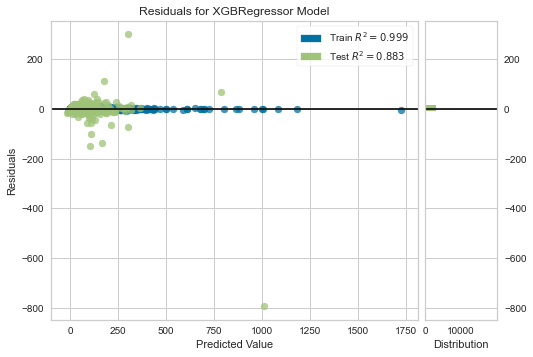

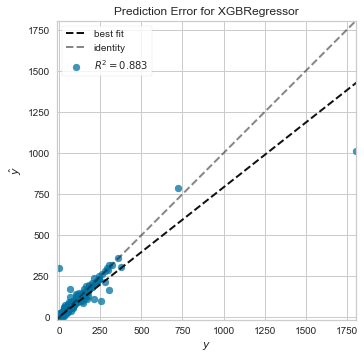

R^2:  0.9999999999999671
RMSE:  8.80460383181295e-06
Needs to be tested.
MASE:  1.6337156561421406e-07


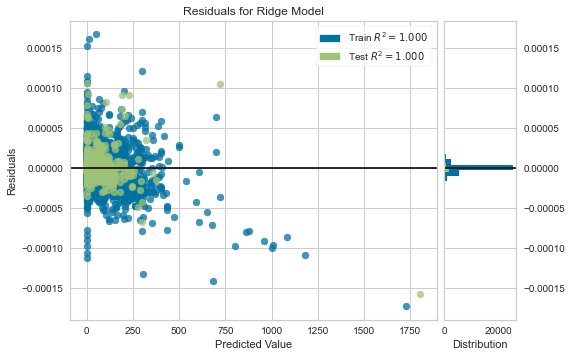

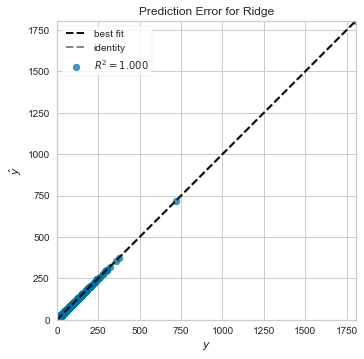

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7590.992722439652, tolerance: 5676.997022325403
  model = cd_fast.enet_coordinate_descent(


R^2:  0.9999927854379195
RMSE:  0.13039725597284627
Needs to be tested.
MASE:  0.0016359457656814616


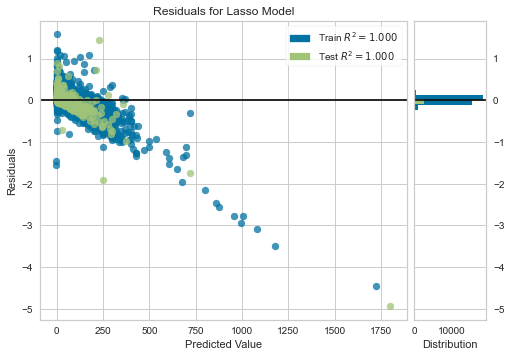

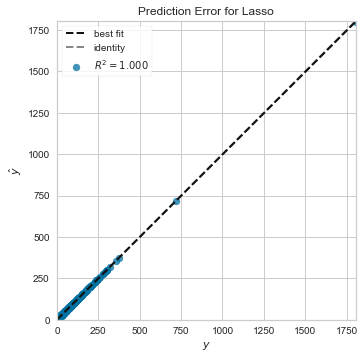

R^2:  0.8313772355298564
RMSE:  19.93524454347358
Needs to be tested.
MASE:  0.0891355621840283


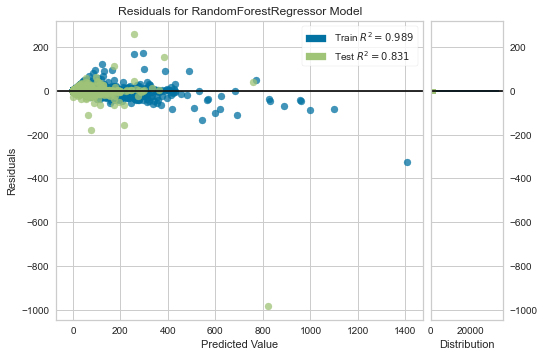

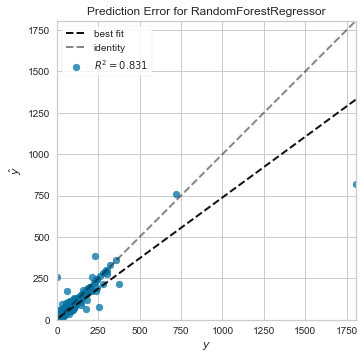

R^2:  0.8152809965625295
RMSE:  20.865041526802262
Needs to be tested.
MASE:  0.09926937260974876


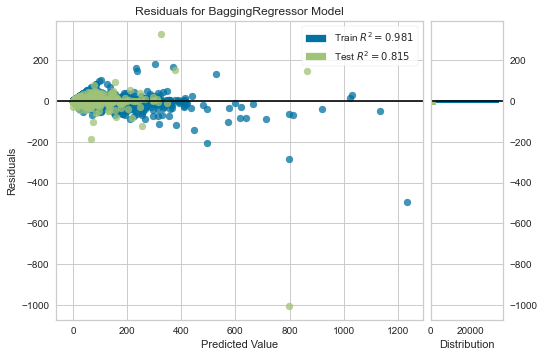

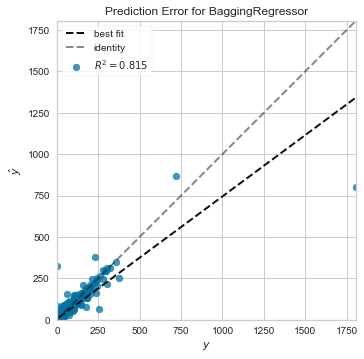

R^2:  0.885873083946177
RMSE:  16.400515761528506
Needs to be tested.
MASE:  0.20784690748976886


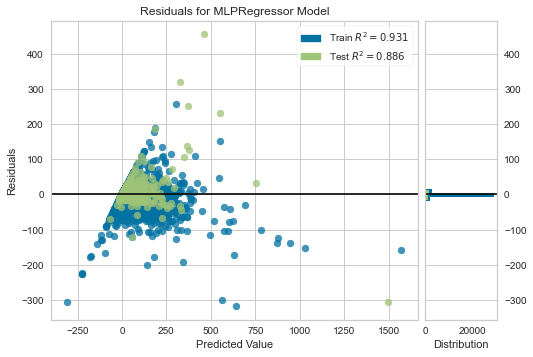

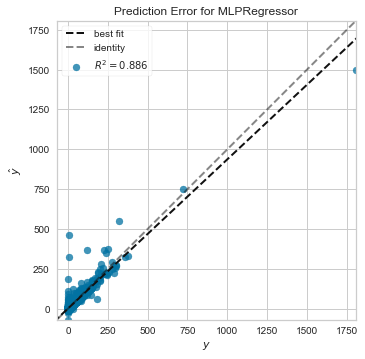

R^2:  0.9999990423291114
RMSE:  0.04750853165566346
Needs to be tested.
MASE:  0.0007628175873863067


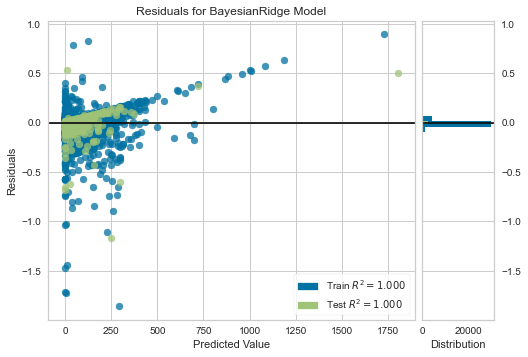

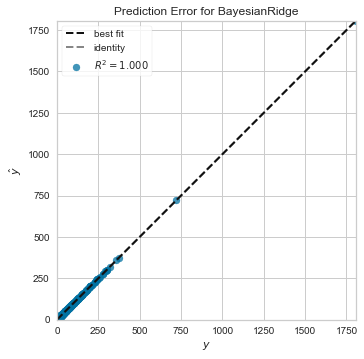

In [13]:
sm_OLS = StatsModelsWrapper(sm.OLS)

test_models = {
    'XGBoost' : XGBRegressor(n_estimators=100),
    'Ridge':Ridge(),
    'Lasso':Lasso(),
    'RandomForest':RandomForestRegressor(),
    'BaggingRegressor':BaggingRegressor(),
    'MLPRegressor':MLPRegressor(),
    'BayesianRidge':BayesianRidge(),
    #'Pooled':sm_OLS
}

In [42]:
sm_OLS = StatsModelsWrapper(sm.OLS)

test_models = {
    'XGBoost' : XGBRegressor(n_estimators=100),
    #'Ridge':Ridge(),
    'Lasso':Lasso(),
    'RandomForest':RandomForestRegressor(),
    #'BaggingRegressor':BaggingRegressor(),
    'MLPRegressor':MLPRegressor(),
    'BayesianRidge':BayesianRidge(),
    'Pooled':sm_OLS
}

"""
def evaluate_dataset(X_train,X_test,y_train,y_test,test_models,show_models=False):
    dev_data = dataset
    
    le = LabelEncoder()
    
    # Which features need to be label for the model
    coded_cols = coded_cols
    for col in coded_cols:
        col_label = col+'_label'
        dev_data[col_label]=  dev_data[col].astype('str')
        dev_data[col_label]= le.fit_transform(dev_data[col])

    # Separate the dependent and independent variables
    # Remove the coded columns and target column
    X = dev_data.drop(columns =  coded_cols + ['stock_distributed'] )
    # Keep these other values for sorting and indexing later
    y = dev_data.loc[:,['site_code','product_code','year','month','stock_distributed']]

    # Inspect the dataset
    #X.head()

    # Replace Inf values NA
    X = X.replace([np.inf, -np.inf], np.nan)

    # Impute missing values in the dataset by incorporating information from the other features
    imp = IterativeImputer(max_iter=10, random_state=42)
    imp.fit(X)

    X_imputed = pd.DataFrame(np.round(imp.transform(X)),columns =X.columns)
    
    # Split the data set in to training and test sets
    # Split the dataset by date to get the most recent three months for evaluation
    X_train = X_imputed[dev_data['year_month']<"2019-07-01"]
    X_test = X_imputed[dev_data['year_month']>="2019-07-01"]

    y_train = y[dev_data['year_month']<"2019-07-01"]
    y_test = y[dev_data['year_month']>="2019-07-01"]

    # Iterate Over and evaluate the models to predict the rest dataset
    model_y_pred = pd.DataFrame()

    for key in test_models.keys():
        print("\n"+"_"*20)
        print(key)
        # Calculate the score
        model = test_models[key]
        model.fit(X_train,y_train['stock_distributed'])
        y_pred = model.predict(X_test)
        model_y_pred[key] = y_pred
        # accuracy and error calcs
        r2, rmse = metrics.r2_score(y_test['stock_distributed'], y_pred), np.sqrt(metrics.mean_squared_error(y_test['stock_distributed'], y_pred))
        print("R^2: ",r2)
        print("RMSE: ",rmse)
        mase = MASE(y_train['stock_distributed'],y_test['stock_distributed'],y_pred)
        print("MASE: ",mase)
        if show_models:
            viz_res_plot = residuals_plot(test_models[key], X_train, y_train['stock_distributed'], X_test, y_test['stock_distributed'])
            viz_prd_error = prediction_error(test_models[key], X_train, y_train['stock_distributed'], X_test, y_test['stock_distributed'])
    model_y_pred.subtract(y_test['stock_distributed'].values,axis = 0).plot()
    return model_y_pred
"""

In [102]:
def evaluate_dataset(X_train,X_test,X_validate,y_train,y_test,test_models,show_models=False):

    # Iterate Over and evaluate the models to predict the rest dataset
    model_predy = pd.DataFrame()
    model_results = pd.DataFrame(columns = ['model','r2','rmse','mase','r2_v','rmse_v','mase_v'])

    for key in test_models.keys():
        print("\n"+"_"*20)
        print(key)
        # Calculate the score
        model = test_models[key]
        model.fit(X_train,y_train['stock_distributed'])
        y_pred = model.predict(X_test)
        y_pred_v = model.predict(X_validate)
        model_predy[key] = y_pred
        # accuracy and error calcs
        r2 = metrics.r2_score(y_test['stock_distributed'], y_pred)
        mase = MASE(y_train['stock_distributed'],y_test['stock_distributed'],y_pred)
        rmse= np.sqrt(metrics.mean_squared_error(y_test['stock_distributed'], y_pred))
        print("R^2: ",r2)
        print("RMSE: ",rmse)
        print("MASE: ",mase)
        # accuracy and error calcs
        r2v = metrics.r2_score(y_test['stock_distributed'], y_pred_v)
        masev = MASE(y_train['stock_distributed'],y_test['stock_distributed'],y_pred_v)
        rmsev = np.sqrt(metrics.mean_squared_error(y_test['stock_distributed'], y_pred_v))
        print("R^2-v: ",r2v)
        print("RMSE-v: ",rmsev)
        print("MASE-v: ",masev)
        model_results = model_results.append([key,r2,rmse,mase,r2v,rmsev,masev])
        
        # Create Several Plot figures to evaluate the model results
        if show_models:
            viz_res_plot = residuals_plot(test_models[key], X_train, y_train['stock_distributed'], X_test, y_test['stock_distributed'])
            viz_prd_error = prediction_error(test_models[key], X_train, y_train['stock_distributed'], X_test, y_test['stock_distributed'])
            viz_FeatureImportances = FeatureImportances(test_models[key])
            viz_FeatureImportances.fit(X_train, y_train['stock_distributed'])
            viz_FeatureImportances.show()

    model_predy.subtract(y_test['stock_distributed'].values,axis = 0).plot()
    print(model_results)
    return model_predy, model_results

In [70]:
coded_cols = ['site_code','product_code','year','month','year_month']

def process_datasets(data,target_col,index_cols):
    """
    Process the data by encoding categorical variables and imputing missing values
    
    """
    try:
        assert type(index_cols) == list
    except:
        print('`index_cols` needs to be a list type')
        raise
    dev_data = data
    
    
    le = LabelEncoder()

    # Which features need to be label for the model
    coded_cols = index_cols
    for col in coded_cols:
        col_label = col+'_label'
        dev_data[col_label]=  dev_data[col].astype('str')
        dev_data[col_label]= le.fit_transform(dev_data[col])

    # Separate the dependent and independent variables
    # Remove the coded columns and target column
    X = dev_data.drop(columns =  index_cols + [target_col] )
    # Keep these other values for sorting and indexing later
    y = dev_data.loc[:, index_cols +[target_col]]
    # Replace Inf values NA
    X = X.replace([np.inf, -np.inf], np.nan)

    
    
    return X_imputed, y


In [72]:
X_imputed, y =  process_datasets(dev_data,'stock_distributed',coded_cols)

In [73]:
array_ts = y['year_month'].unique()
vals.sort()
vals

array(['2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28',
       '2016-05-28', '2016-06-28', '2016-07-28', '2016-08-28',
       '2016-09-28', '2016-10-28', '2016-11-28', '2016-12-28',
       '2017-01-28', '2017-02-28', '2017-03-28', '2017-04-28',
       '2017-05-28', '2017-06-28', '2017-07-28', '2017-08-28',
       '2017-09-28', '2017-10-28', '2017-11-28', '2017-12-28',
       '2018-01-28', '2018-02-28', '2018-03-28', '2018-04-28',
       '2018-05-28', '2018-06-28', '2018-07-28', '2018-08-28',
       '2018-09-28', '2018-10-28', '2018-11-28', '2018-12-28',
       '2019-01-28', '2019-02-28', '2019-03-28', '2019-04-28',
       '2019-05-28', '2019-06-28', '2019-07-28', '2019-08-28',
       '2019-09-28'], dtype=object)

In [108]:
def create_validation_sets(x,y,x_features,windows):
    """
    Create a dataset to do evaluations with.
    
    """
    array_steps = y['year_month'].unique()
    array_steps.sort()
    
    # Select Target variables
    #X = x.drop(columns =  x_features )
    X = x.fillna(0)
    
    # create split train,test and validate
    # Split the data set in to training and test sets
    # Split the dataset by date to get the most recent three months for evaluation
    X_train = X[y['year_month'].isin(array_steps[:-windows])].select(columns =  x_features )
    X_test = X[~y['year_month'].isin(array_steps[:-windows])].select(columns =  x_features )

    y_train = y[y['year_month'].isin(array_steps[:-windows])]
    y_test = y[~y['year_month'].isin(array_steps[:-windows])]
    
    # Impute missing values in the dataset by incorporating information from the other features
    imputer = IterativeImputer(max_iter=10, random_state=42)
    imputer.fit(X_train)
    
    # Impute the missing data
    X_train= pd.DataFrame(np.round(imputer.transform(X_train)),columns =X_train.columns)
    
    # Create a test dataset by imputing values from a matrix of zeroes
    # We will use this dataset to imagine if we had no information to make a prediction
    X_validate = np.zeros(X_test.shape)
    X_validate = pd.DataFrame(np.round(imputer.transform(X_validate)),columns =X_test.columns)
    
    return X_train, X_test, X_validate, y_train, y_test
    

In [109]:
original_cols = ['stock_initial', 'stock_received','stock_adjustment', 
                    'stock_end', 'average_monthly_consumption',
                    'stock_stockout_days','stock_ordered']

In [111]:
X_train, X_test, X_validate, y_train, y_test = create_validation_sets(
    x = X_train,
    y = y,
    x_features = original_cols,
    windows = 3)

<ipython-input-108-4a24abfb6379>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X[y['year_month'].isin(array_steps[:-windows])].select(columns =  x_features )


AttributeError: 'DataFrame' object has no attribute 'select'

In [107]:
X_test.fillna(0)

,average_monthly_consumption_max3,average_monthly_consumption_max6,average_monthly_consumption_min12,average_monthly_consumption_min3,average_monthly_consumption_min6,district_label,month_label,out_of_stock_during_period,product_code_label,region_label,...,stock_received_lv_1yr,stock_received_max12,stock_received_max3,stock_received_max6,stock_received_min12,stock_received_min3,stock_received_min6,stock_stockout_days,year_label,year_month_label
1,26.0,26.0,20.0,20.0,20.0,25,6,0,7,0,...,0.0,100.0,50.0,50.0,0.0,0.0,0.0,0,3,42
8,1.0,2.0,0.0,1.0,1.0,18,7,0,4,15,...,0.0,100.0,3.0,3.0,0.0,0.0,0.0,0,3,43
12,66.0,66.0,28.0,50.0,28.0,1,6,0,4,1,...,0.0,150.0,100.0,150.0,0.0,0.0,0.0,0,3,42
13,5.0,12.0,0.0,0.0,0.0,44,6,0,2,16,...,0.0,26.0,9.0,26.0,0.0,0.0,0.0,0,3,42
16,21.0,44.0,21.0,21.0,21.0,71,7,0,4,12,...,0.0,125.0,0.0,125.0,0.0,0.0,0.0,0,3,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38737,22.0,29.0,17.0,19.0,19.0,56,6,0,2,16,...,0.0,64.0,32.0,32.0,0.0,0.0,0.0,0,3,42
38766,0.0,3.0,0.0,0.0,0.0,61,7,0,5,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,43
38774,32.0,33.0,0.0,25.0,17.0,50,8,0,5,18,...,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0,3,44
38819,0.0,0.0,0.0,0.0,0.0,18,7,1,8,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,3,43


In [103]:
model_predy, model_results = evaluate_dataset(X_train.fillna(0),
                                              X_test.fillna(0),
                                              X_validate.fillna(0),
                                              y_train,
                                              y_test,
                                              test_models,
                                              show_models=False)


____________________
XGBoost
Needs to be tested.
R^2:  0.6423323950941261
RMSE:  29.03375904299888
MASE:  0.2969235463112605
Needs to be tested.
R^2-v:  -0.12164127203462649
RMSE-v:  51.41507286199624
MASE-v:  0.7081087070263826

____________________
Lasso


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109372.7954588213, tolerance: 5676.997022325403
  model = cd_fast.enet_coordinate_descent(


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

/usr/local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"



____________________
XGBoost
R^2:  0.882961648200711
RMSE:  16.608391113360607
Needs to be tested.
MASE:  0.08364979075980275

____________________
Lasso


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7590.992722439652, tolerance: 5676.997022325403
  model = cd_fast.enet_coordinate_descent(


R^2:  0.9999927854379195
RMSE:  0.13039725597284627
Needs to be tested.
MASE:  0.0016359457656814616

____________________
RandomForest
R^2:  0.840438502310358
RMSE:  19.392219442626327
Needs to be tested.
MASE:  0.08825276813656167

____________________
MLPRegressor
R^2:  -9.150152425189887
RMSE:  154.667742614091
Needs to be tested.
MASE:  0.4543914706731898

____________________
BayesianRidge
R^2:  0.9999990423291114
RMSE:  0.04750853165566346
Needs to be tested.
MASE:  0.0007628175873863067

____________________
Pooled
R^2:  1.0
RMSE:  1.684020173366697e-12
Needs to be tested.
MASE:  2.946844404439782e-14


,XGBoost,Lasso,RandomForest,MLPRegressor,BayesianRidge,Pooled
0,26.860645,26.981662,27.04,27.950784,27.017254,NaN
1,27.637423,24.917875,16.98,15.090664,24.989945,27.0
2,74.438026,73.915848,73.37,77.631743,74.042517,NaN
3,11.538290,9.981967,10.00,7.380137,10.007481,NaN
4,1.521336,0.077491,0.00,6.119156,0.000648,NaN
...,...,...,...,...,...,...
3084,17.797461,18.000038,20.02,17.924850,17.992313,NaN
3085,0.006724,0.007681,0.00,-1.248247,0.003194,NaN
3086,48.496124,49.919824,50.00,48.190430,50.027505,NaN
3087,0.006724,0.007672,0.00,-0.643201,-0.063645,NaN


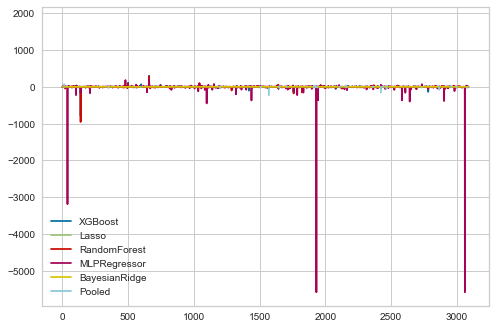

In [43]:
model_predy, model_results = evaluate_dataset(dev_data,coded_cols,test_models)

In [28]:
product_data = pd.read_csv("analytical_data/product_data.csv")#.loc[:,['product_code','cluster']]
site_data = pd.read_csv("analytical_data/augmented_site_info.csv")

district_data = pd.read_csv("analytical_data/augmented_district_cluster.csv")#.loc[:,['site_code','cluster']]

In [33]:
print(len(site_data))
site_district_data = site_data.merge(district_data,left_on='site_district',right_on='district')
print(len(site_district_data))
# Note we lose one record in the merge

156
155


In [35]:
dev_data.head()

,site_code,product_code,year_month,year,month,region,district,stock_initial,stock_received,stock_distributed,...,stock_adjustment_max12,stock_end_max12,average_monthly_consumption_max12,region_label,district_label,site_code_label,product_code_label,year_month_label,year_label,month_label
0,C1087,AS27133,2018-09-28,2018,9,SUD-COMOE,GRAND-BASSAM,325,0,100,...,150.0,450.0,158.0,17,36,41,4,32,2,8
1,C1088,AS27138,2019-07-28,2019,7,ABIDJAN 1-GRANDS PONTS,DABOU,34,0,27,...,0.0,132.0,36.0,0,25,42,7,42,3,6
2,C2064,AS27000,2018-06-28,2018,6,GBOKLE-NAWA-SAN PEDRO,SOUBRE,822,0,150,...,120.0,1794.0,313.0,7,65,91,2,29,2,5
3,C1073,AS27138,2018-09-28,2018,9,ABIDJAN 1-GRANDS PONTS,YOPOUGON-EST,16,0,5,...,0.0,50.0,9.0,0,77,32,7,32,2,8
4,C5006,AS27139,2016-08-28,2016,8,TONKPI,ZOUAN-HOUNIEN,0,0,0,...,NaN,NaN,NaN,18,79,144,8,7,0,7


In [39]:
product_info = product_data.loc[:,['product_code','cluster_product']]
district_info = site_district_data.loc[:,['site_code','cluster_district']]

analytical_dataset = dev_data.merge(product_info,on='product_code')
analytical_dataset = analytical_dataset.merge(district_info,left_on = 'site_code' ,right_on='site_code')

/usr/local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


R^2:  0.893029015988695
RMSE:  15.891580041776619
Needs to be tested.
MASE:  0.12352169497581862


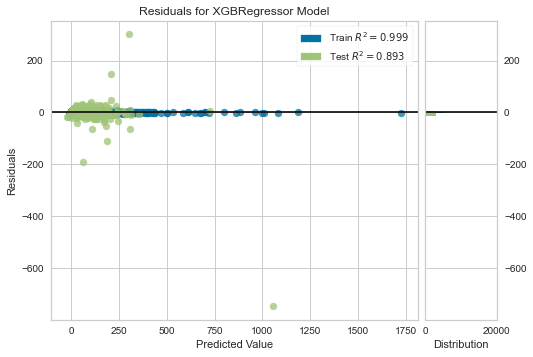

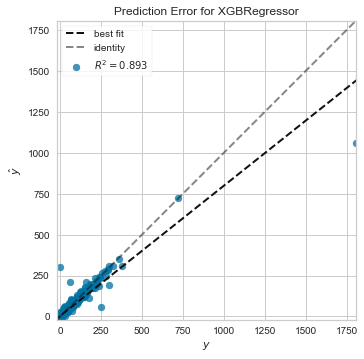

R^2:  0.999999999999958
RMSE:  9.953695025790092e-06
Needs to be tested.
MASE:  2.6353600026413726e-07


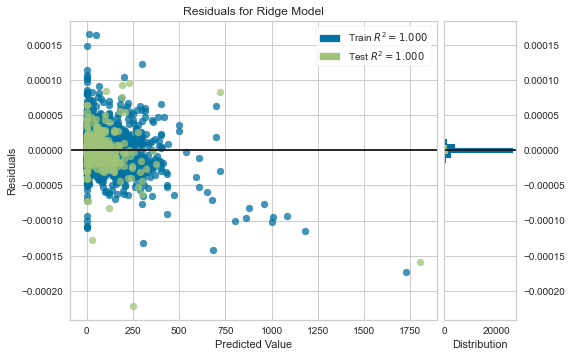

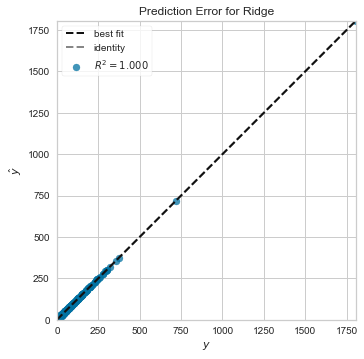

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7590.605570059617, tolerance: 5676.997022325404
  model = cd_fast.enet_coordinate_descent(


R^2:  0.9999927994127921
RMSE:  0.13038212096144267
Needs to be tested.
MASE:  0.0024820919586392154


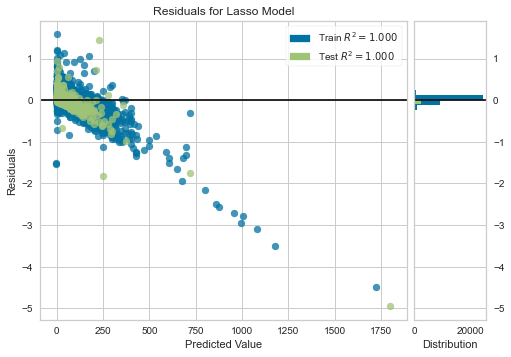

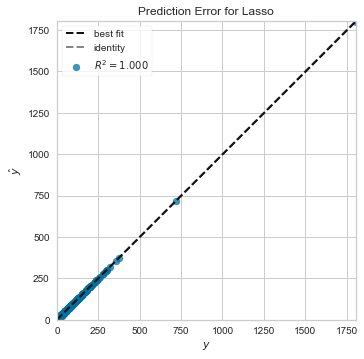

R^2:  0.8185660486771501
RMSE:  20.69633110356114
Needs to be tested.
MASE:  0.1376407852294013


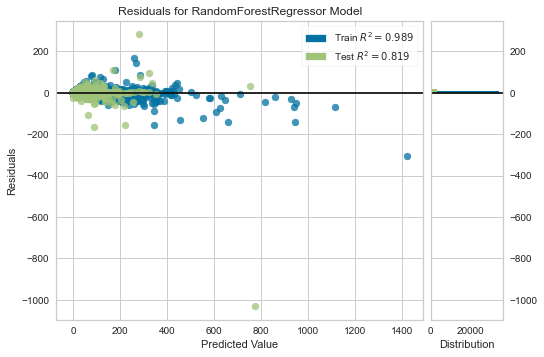

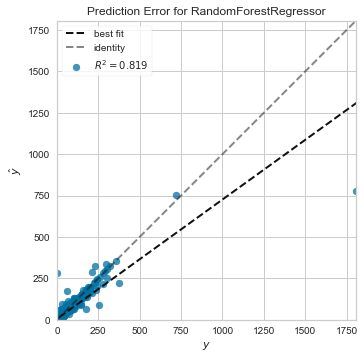

R^2:  0.7888172214763767
RMSE:  22.328694617206484
Needs to be tested.
MASE:  0.15448707122492447


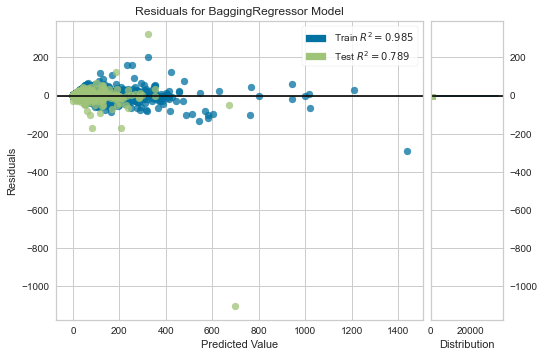

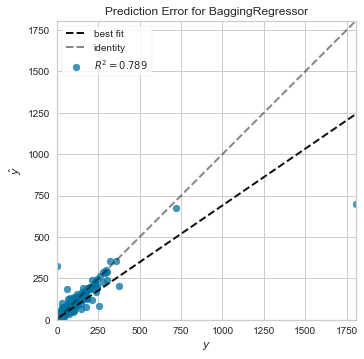

R^2:  0.9700621010407442
RMSE:  8.407071546563266
Needs to be tested.
MASE:  0.15432806908534646


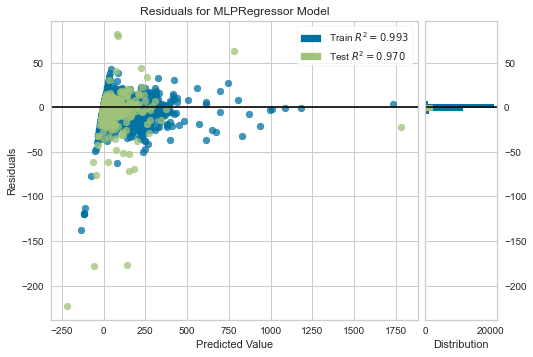

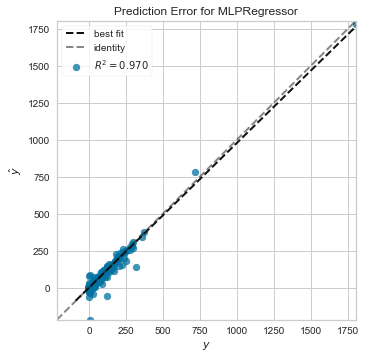

R^2:  0.9971018555240024
RMSE:  2.615737147867792
Needs to be tested.
MASE:  0.07185501194467893


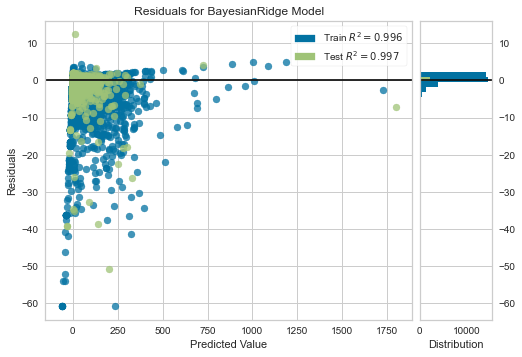

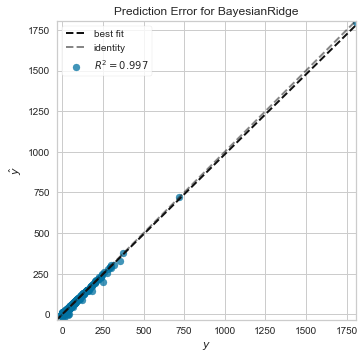

,XGBoost,Ridge,Lasso,RandomForest,BaggingRegressor,MLPRegressor,BayesianRidge
0,171.314804,2.000000e+02,199.722900,165.76,186.3,201.259454,199.298883
1,153.624374,1.500000e+02,149.838076,154.50,153.3,118.888365,143.582618
2,170.913788,1.750000e+02,174.846786,176.52,173.4,178.483261,175.890022
3,100.157913,9.999999e+01,99.754548,100.00,100.0,98.512667,100.855103
4,18.319706,2.000000e+01,20.039140,28.34,27.3,19.814033,20.138153
...,...,...,...,...,...,...,...
3078,0.351516,5.145466e-06,0.026897,0.06,0.0,-0.619048,0.922883
3079,0.136933,-1.355526e-06,0.016472,0.00,0.0,-0.390295,0.737085
3080,-0.008040,-1.078609e-07,0.008332,0.00,0.0,0.806604,0.922883
3081,-0.015426,-3.573746e-07,0.008143,0.00,0.0,-1.081299,0.922883


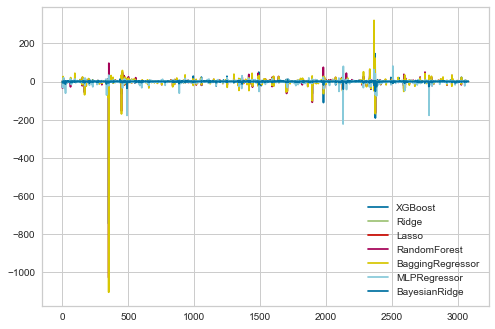

In [40]:
evaluate_dataset(analytical_dataset,coded_cols+['cluster_product','cluster_district'],test_models)